In [2]:
#!pip install pandas pyarrow
#!pip install findspark
#!pip install pyspark
'''from pyarrow import csv, parquet
import os
import pyarrow.parquet as pq

def parse_csvs():
    #Concatenates pandas by month
    monthly_li =  ["%02d" % i for i in range(1,11)]
    df_wbb = pd.DataFrame()
    for mon in monthly_li:
        t1 = datetime.now()
        df_jan = pd.read_csv(f'./df_{mon}.csv')
        #df_wbb = df_jan.loc[df_jan['Station'] == 'WBB']
        df_wbb = pd.concat([df_wbb,df_jan])
        t2 = datetime.now()
        took = t2 - t1
        print(f"it took {took} seconds to parse month {mon}.")
    df_wbb.shape
    return df_wbb'''

'from pyarrow import csv, parquet\nimport os\nimport pyarrow.parquet as pq\n\ndef parse_csvs():\n    #Concatenates pandas by month\n    monthly_li =  ["%02d" % i for i in range(1,11)]\n    df_wbb = pd.DataFrame()\n    for mon in monthly_li:\n        t1 = datetime.now()\n        df_jan = pd.read_csv(f\'./df_{mon}.csv\')\n        #df_wbb = df_jan.loc[df_jan[\'Station\'] == \'WBB\']\n        df_wbb = pd.concat([df_wbb,df_jan])\n        t2 = datetime.now()\n        took = t2 - t1\n        print(f"it took {took} seconds to parse month {mon}.")\n    df_wbb.shape\n    return df_wbb'

In [2]:
example = pd.read_csv("./all_2022.csv")

In [3]:
#Q: can I fit all stations into 1km squre and have at least one neighboring station?
#example = pd.read_csv('./df_05.csv')

In [ ]:
'''for station in example['Station'].unique():
    # Sometimes, columns rewrite as NaNs because they have different index - less values ..etc...
    station_lat= example['Latitude'].loc[example['Station']==station].unique()
    station_lon= example['Longitude'].loc[example['Station']==station].unique()
    #stat = example.loc[['Station']=='HOL']
    # + 0.013 is 1 km - lets make it 2 - 0.026
    upper_lat = float(station_lat) + 0.013
    upper_lon = float(station_lon) + 0.013
    lower_lat = float(station_lat) - 0.013
    lower_lon = float(station_lon) - 0.013
    station_li= example['Station'].loc[(example['Latitude'].between(lower_lat,upper_lat)) & (example['Longitude'].between(lower_lon,upper_lon))].unique()
    print(station, len(station_li))'''
    #['HOL' 'CLK' 'OC1WX' 'D0231' 'E9449' 'UTOLY' 'UT224' 'PC023' 'UTTAY', 'G0195' 'CTBST']

In [4]:
example = example.set_index('(Index) -> Time')

In [ ]:
# GET WINDOW AROUND STATION, create diff, shifts
import matplotlib
from sklearn import linear_model
from sklearn.model_selection import train_test_split
# Define area of square 0.013 = 1 km2
window = 0.026
for station in example['Station'].unique():
    station_lat= example['Latitude'].loc[example['Station']==station].unique()
    station_lon= example['Longitude'].loc[example['Station']==station].unique()
    #stat = example.loc[['Station']=='HOL']
    # + 0.013 is 1 km - lets make it 2 - 0.026
    upper_lat = float(station_lat) + window
    upper_lon = float(station_lon) + window
    lower_lat = float(station_lat) - window
    lower_lon = float(station_lon) - window
    station_li= example['Station'].loc[(example['Latitude'].between(lower_lat,upper_lat)) & (example['Longitude'].between(lower_lon,upper_lon))].unique()
    print(f'{station} station has  {len(station_li)} neighbors.')
    reg_df = pd.DataFrame()
    for neighb in station_li:
        t_st = example['yo_t'].loc[example['Station']==neighb]
        reg_df[str(neighb)] = t_st
    
    tes_val = station
    predictors = reg_df.keys()
    #predictors = predictors.drop(tar_val)
    prep_df = reg_df[predictors].dropna()
    a = [-9999]
    prep_df = prep_df[~prep_df[predictors].isin(a)]
    X = prep_df.drop([tes_val],axis=1)
    y = prep_df[tes_val]
    if X.shape[0] < 48:
        pass
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
        print("Splitting dataset complete!")
        print("-"*30)
        try:
            BR = linear_model.BayesianRidge()
            BR.fit(X_train,y_train)
            print("Training complete!")
            print("-"*30)
            plt.rcParams['figure.figsize'] = (6.0, 6.0)
            preds = pd.DataFrame({"preds":BR.predict(X_test), "true":y_test})
            preds["residuals"] = preds["true"] - preds["preds"]
            preds["abs_res"] = preds['residuals'].apply(lambda x: abs(x))
            descr = preds.describe()
            print(f'For {station} matrix is:')
            print(descr)
        except ValueError:
            pass

In [7]:
# Do Bayes Regres Ridge without changes for one month!
import matplotlib
from sklearn import linear_model
from sklearn.model_selection import train_test_split 
tes_val = 'SOLSM'
predictors = reg_df.keys()
#predictors = predictors.drop(tar_val)
prep_df = reg_df[predictors].dropna()
X = prep_df.drop([tes_val],axis=1)
y = prep_df[tes_val]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
print("Splitting dataset complete!")
print("-"*30)
BR = linear_model.BayesianRidge()
BR.fit(X_train,y_train)
print("Training complete!")
print("-"*30)
plt.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":BR.predict(X_test), "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds["abs_res"] = preds['residuals'].apply(lambda x: abs(x))

Splitting dataset complete!
------------------------------
Training complete!
------------------------------


In [15]:
preds.describe()

,preds,true,residuals,abs_res
count,1083.000000,1083.000000,1083.000000,1083.000000
mean,0.018525,-0.044940,-0.063465,0.831582
std,0.699421,1.286027,1.095757,0.715924
min,-1.995683,-3.290000,-3.794209,0.003483
25%,-0.481906,-0.920000,-0.743554,0.293335
50%,-0.008111,-0.170000,-0.069589,0.645145
75%,0.489346,0.720000,0.521906,1.178632
max,2.651983,6.030000,4.565034,4.565034


In [11]:
import warnings
warnings.filterwarnings("ignore")

def create_shifts(df,periods,column_name_li):
  #Creates shifts in periods for dataframe and names i.e. what is value in previous one or two terms?
    for name_li in column_name_li:
        df[str(name_li) + "sh_" + str(periods)] = df[name_li].shift(periods = periods)
    return df

def create_differences(df,periods,column_name_li):
    # Yields a lot of warnings - figure it out
    for name_li in column_name_li:
        df[str(name_li) + "dif_" + str(periods)] = df[name_li].diff(periods = periods)
    return df

######################



In [ ]:
tes_val = 'SOLSM'
def reg_neig_station(df,station,tes_val):
    df_wbb2 = df
    
    #gernerate list of interesting features
    df_wbb2 = df_wbb2.loc[df_wbb2[tes_val] != -9999]
    nw_li = [st+ap for ap in feat2_li for st in feat_li ]
    feat_to_plot = [('d_'+str(j)) for j in ['t','td','u','v','ws','rh']]
    df1 = df_wbb2[feat_to_plot]
    for tm_sp in [1,2]:
        df_wbb2 = create_shifts(df_wbb2, tm_sp, df1.keys())

    for tm_sp in [1,2]:
        df_wbb2 = create_differences(df_wbb2, tm_sp, df1.keys())

    dif_li = [tes_val+'dif_'+str(n) for n in [1,2]]
    sh_li = [tes_val+'sh_'+str(n) for n in [1,2]]
    feat_li = [tes_val] + dif_li+sh_li
    prep_df = df_wbb2[feat_li].dropna()
    if prep_df.shape[0] < 23:
        a = "Not enough data in {} station dataset".format(station)
    else:
        X = prep_df.drop([tes_val],axis=1)
        y = prep_df[tes_val]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
        print("Splitting dataset complete!")
        print("-"*30)
        BR = linear_model.BayesianRidge()
        BR.fit(X_train,y_train)
        print("Training complete!")
        print("-"*30)
        plt.rcParams['figure.figsize'] = (6.0, 6.0)
        preds = pd.DataFrame({"preds":BR.predict(X_test), "true":y_test})
        preds["residuals"] = preds["true"] - preds["preds"]
        preds["abs_res"] = preds['residuals'].apply(lambda x: abs(x))
        a = preds.describe()
        print(station)
        print("-"*30)
    return a

In [13]:
 reg_df.keys()

Index(['SOL', 'SOLSM', 'SOLAP', 'SOLHP', 'SOLsh_1', 'SOLSMsh_1', 'SOLAPsh_1',
       'SOLHPsh_1', 'SOLsh_2', 'SOLSMsh_2',
       ...
       'SOLAPsh_3sh_4dif_1dif_3dif_4dif_5sh_1sh_2sh_3sh_4',
       'SOLHPsh_3sh_4dif_1dif_3dif_4dif_5sh_1sh_2sh_3sh_4',
       'SOLsh_1sh_3sh_4dif_1dif_3dif_4dif_5sh_1sh_2sh_3sh_4',
       'SOLSMsh_1sh_3sh_4dif_1dif_3dif_4dif_5sh_1sh_2sh_3sh_4',
       'SOLAPsh_1sh_3sh_4dif_1dif_3dif_4dif_5sh_1sh_2sh_3sh_4',
       'SOLHPsh_1sh_3sh_4dif_1dif_3dif_4dif_5sh_1sh_2sh_3sh_4',
       'SOLsh_2sh_3sh_4dif_1dif_3dif_4dif_5sh_1sh_2sh_3sh_4',
       'SOLSMsh_2sh_3sh_4dif_1dif_3dif_4dif_5sh_1sh_2sh_3sh_4',
       'SOLAPsh_2sh_3sh_4dif_1dif_3dif_4dif_5sh_1sh_2sh_3sh_4',
       'SOLHPsh_2sh_3sh_4dif_1dif_3dif_4dif_5sh_1sh_2sh_3sh_4'],
      dtype='object', length=65084)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

def create_shifts(df,periods,column_name_li):
  #Creates shifts in periods for dataframe and names i.e. what is value in previous one or two terms?
    for name_li in column_name_li:
        df[str(name_li) + "sh_" + str(periods)] = df[name_li].shift(periods = periods)
    return df

def create_differences(df,periods,column_name_li):
    for name_li in column_name_li:
        df[str(name_li) + "dif_" + str(periods)] = df[name_li].diff(periods = periods)
    return df

######################
def get_acc_for_station(df,station,tes_val):
    df_wbb2 = df
    #gernerate list of interesting features
    feat_li = ['yo_', 'd_', 'xb_', 'xa_', 'stdev_']
    feat2_li = ['t','td','u','v','ws','rh'] 
    df_wbb2 = df_wbb2.loc[df_wbb2[tes_val] != -9999]
    nw_li = [st+ap for ap in feat2_li for st in feat_li ]
    feat_to_plot = [('d_'+str(j)) for j in ['t','td','u','v','ws','rh']]
    df1 = df_wbb2[feat_to_plot]
    for tm_sp in [1,2,3,4,5]:
        df_wbb2 = create_shifts(df_wbb2, tm_sp, df1.keys())

    for tm_sp in [1,2,3,4,5]:
        df_wbb2 = create_differences(df_wbb2, tm_sp, df1.keys())

    dif_li = [tes_val+'dif_'+str(n) for n in [1,2,3,4,5]]
    sh_li = [tes_val+'sh_'+str(n) for n in [1,2,3,4,5]]
    feat_li = [tes_val] + dif_li+sh_li
    prep_df = df_wbb2[feat_li].dropna()
    if prep_df.shape[0] < 23:
        a = "Not enough data in {} station dataset".format(station)
    else:
        X = prep_df.drop([tes_val],axis=1)
        y = prep_df[tes_val]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
        print("Splitting dataset complete!")
        print("-"*30)
        BR = linear_model.BayesianRidge()
        BR.fit(X_train,y_train)
        print("Training complete!")
        print("-"*30)
        plt.rcParams['figure.figsize'] = (6.0, 6.0)
        preds = pd.DataFrame({"preds":BR.predict(X_test), "true":y_test})
        preds["residuals"] = preds["true"] - preds["preds"]
        preds["abs_res"] = preds['residuals'].apply(lambda x: abs(x))
        a = preds.describe()
        print(station)
        print("-"*30)
    return a

#df_one = df_wbb.loc[df_jan['Station'] == 'HOL']

import matplotlib
from sklearn import linear_model
from sklearn.model_selection import train_test_split 
#gernerate list of interesting features
feat_li = ['yo_', 'd_', 'xb_', 'xa_', 'stdev_']
feat2_li = ['t','td','u','v','ws','rh'] 
nw_li = [st+ap for ap in feat2_li for st in feat_li ]
feat_to_plot = [('d_'+str(j)) for j in ['t','td','u','v','ws','rh']]
df1 = df_wbb[feat_to_plot]


for stat in df_wbb['Station'].unique():
    df_one = df_wbb.loc[df_wbb['Station'] ==stat]
    for tm_sp in [1,2,3,4,5]:
        df_one = create_shifts(df_one, tm_sp, df1.keys())

    for tm_sp in [1,2,3,4,5]:
        df_one = create_differences(df_one, tm_sp, df1.keys())
    
    z = get_acc_for_station(df_one,stat,'d_ws')
    print(z)


In [36]:
len(df_wbb['Station'].unique())

412

In [20]:
# Python version is 3.9.13 so I can use pyarrow
monthly_li =  ["%02d" % i for i in range(6,12)]
for mon in monthly_li:
    print(f"Filtering {mon}")
    t1 = datetime.now()
    path = f"/uufs/chpc.utah.edu/common/home/u0035056/uu2dvar/csv/2022{mon}*.csv"
    filenames = glob.glob(path)
    df_wbb_JAN = pd.DataFrame()
    for filename in filenames:
        df= pd.read_csv(filename, delimiter=',',index_col=0,header=0,skiprows=[1])
        df1 = df[(df.Latitude<41.34) & (df.Latitude > 40.17) & (df.Longitude < -111.346) & (df.Longitude > -112.678)]
        df_wbb_JAN=pd.concat([df_wbb_JAN,df1])
    t2 = datetime.now()
    took = t2 - t1
    print(f"it took {took} seconds to parse {mon} month.")
    df_wbb_JAN.to_csv(f'./df_{mon}.csv')

Filtering 06
it took 0:02:37.083232 seconds to parse 06 month.
Filtering 07
it took 0:03:17.384173 seconds to parse 07 month.
Filtering 08
it took 0:03:36.063589 seconds to parse 08 month.
Filtering 09
it took 0:03:30.762207 seconds to parse 09 month.
Filtering 10
it took 0:03:34.102924 seconds to parse 10 month.
Filtering 11
it took 0:00:03.415067 seconds to parse 11 month.


In [ ]:
def get_dat_for_coordinates(months_start,months_end,lat1 = 41.34,lat2 = 40.17 ,lon1 = -111.346,lon2 = -112.678):
	monthly_li =  ["%02d" % i for i in range(months_start,months_end)] # generates list of months in string format ’01’, ’02’…
	for mon in monthly_li:
    		print(f"Filtering {mon}")
    		t1 = datetime.now()
    		path = f"/uufs/chpc.utah.edu/common/home/u0035056/uu2dvar/csv/2022{mon}*.csv"
    		filenames = glob.glob(path)
    		df_wbb_mon = pd.DataFrame()
    	for filename in filenames:
        		df= pd.read_csv(filename, delimiter=',',index_col=0,header=0,skiprows=[1])
        		df1 = df[(df.Latitude< lat1) & (df.Latitude > lat2) & (df.Longitude < lon1) & (df.Longitude > lon2)]
        		df_wbb_mon=pd.concat([df_wbb_mon,df1])
    	t2 = datetime.now()
    	took = t2 - t1
    	print(f"it took {took} seconds to parse {mon} month.")
    	df_wbb_mon.to_csv(f'./df_{mon}.csv')
return df_wbb_mon

In [ ]:
import os
from os import listdir
from os.path import isfile, join


"""li_files = []
for file_name in os.listdir('./Parquets'):
    li_files.append(file_name)"""

table = pq.read_table(f'./Parquets/2022030813.parquet', filters=[('Latitude', '>', 40.17),('Latitude', '<', 41.34),('Longitude', '>', -112.678),('Longitude', '<', -111.346)])

#for nam in li_files[1:30]:
#    table = pq.read_table(f'./Parquets/{filename}', filters=[('Station', '==', 'WBB'),])'''

In [23]:
table = pq.read_table('./combined.parquet_FEB', filters=[('Station', '==', 'WBB')])

In [24]:
hol_df = table.to_pandas()

In [29]:
def file_to_data_frame_to_parquet(local_file: str, parquet_file: str) -> None:
    table = csv.read_csv(local_file)
    parquet.write_table(table, parquet_file)

In [ ]:
def combine_parquet_files2(input_folder, target_path,i,j):
    try:
        files = []
        for file_name in os.listdir(input_folder)[i:j]:
            files.append(pq.read_table(os.path.join(input_folder, file_name)))
        with pq.ParquetWriter(target_path,
                files[0].schema,
                version='2.0',
                compression='gzip',
                use_dictionary=True,
                data_page_size=2097152, #2MB
                write_statistics=True) as writer:
            for f in files:
                writer.write_table(f)
    except Exception as e:
        print(e)


In [ ]:
for i in range(0,300,30):
    j = i+30
    combine_parquet_files2('./Parq_mon/', f'./Parq_big/combined{i}.parquet',i,j)

In [47]:
table = pq.read_table('./Parq_big/combined180.parquet', filters=[('Station', '==', 'HOL')])

In [48]:
hol_df = table.to_pandas()

In [50]:
hol_df.shape

(210, 67)

In [60]:
import pandas as pd
idx = [30,60,90,120,150,180]
HOL_df = pd.DataFrame()
for i in idx:
    table = pq.read_table(f'./Parq_big/combined{i}.parquet', filters=[('Station', '==', 'WBB')])
    #table1 = pa.concat_tables([table1,table])
    hol_df = table.to_pandas()
    HOL_df = pd.concat([HOL_df, hol_df])
    #

In [61]:
HOL_df.to_csv('WBB_parq_df.csv')

In [69]:
HOL_df['yo_t'] = HOL_df['yo_t'].apply(lambda x: float(x))

<AxesSubplot:>

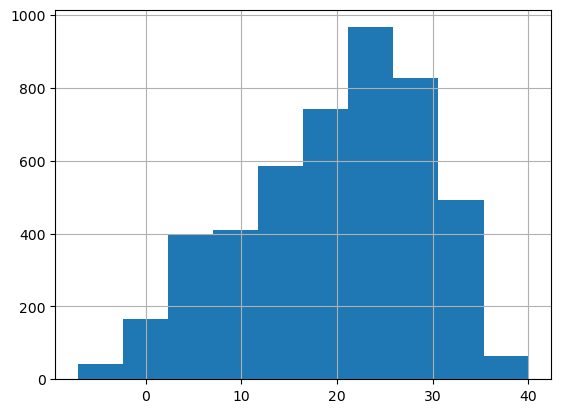

In [70]:
HOL_df['yo_t'].hist()

In [ ]:
#"test/Parquets/2022010100.parquet"

for i in range(31):
    num = "%02d" % i
days = ["%02d" % i for i in range(32)]
print(days)
import re
for month in ['01','02','03']:
    file_nam = './Pa'

In [ ]:
import pyspark
from pyspark.sql import SparkSession
'''spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate()

df=spark.read.option("header",True) \
        .csv("./combined.parquet")
df.printSchema()'''

spark = SparkSession.builder.master("local[1]") \
                    .appName('SparkByExamples.com') \
                    .getOrCreate()
df=spark.read.option("header",True) \
        .csv("./combined.parquet")


In [ ]:
table.to_pandas()
df.printSchema()

In [ ]:
def get_acc_for_station(station):
    for filename in filenames:
    df= pd.read_csv(filename, delimiter=',',index_col=0,header=0,skiprows=[1])
    df1 = df[df.Station=='WBB']
    
    return

In [ ]:
# Python version is 3.9.13 so I can use pyarrow
filenames = glob.glob("/uufs/chpc.utah.edu/common/home/u0035056/uu2dvar/csv/2022*.csv")
#li_st = ['HOL', 'SNI', 'SBE', 'SB2','PCB', 'PCT', 'SNV' ,'MBY', 'DVE']
li_st = ['SNI', 'SBE', 'SB2','PCB', 'PCT', 'SNV' ,'MBY', 'DVE']
print(len(filenames))
'''for filename in filenames:
    df = pd.read_csv(filename, delimiter=',',index_col=0,header=0,skiprows=[1], engine="pyarrow")
    df.to_parquet("./{}.parquet".format(filename), compression=None)'''

'''for station in li_st:
    df_wbb = pd.DataFrame()
    for filename in filenames:
        df= pd.read_csv(filename, delimiter=',',index_col=0,header=0,skiprows=[1], engine="pyarrow")
        df1 = df[df.Station==station]
#       display(df1)
        df_wbb=pd.concat([df_wbb,df1])
    df_wbb.to_csv('./'+station+'2022.csv')'''

In [ ]:
filenames = glob.glob("/uufs/chpc.utah.edu/common/home/u0035056/uu2dvar/csv/2022*.csv")

In [ ]:
# Now try to get understand values of differences
def create_shifts(df,periods,column_name_li):
  #Creates shifts in periods for dataframe and names i.e. what is value in previous one or two terms?
    for name_li in column_name_li:
        df[str(name_li) + "sh_" + str(periods)] = df[name_li].shift(periods = periods)
    return df

def create_differences(df,periods,column_name_li):
    for name_li in column_name_li:
        df[str(name_li) + "dif_" + str(periods)] = df[name_li].diff(periods = periods)
    return df

In [ ]:
# Get data file names      
'''filenames = glob.glob("/uufs/chpc.utah.edu/common/home/u0035056/uu2dvar/csv/20220101*.csv")
#print(filenames)
df_wbb = pd.DataFrame()
for filename in filenames:
    df= pd.read_csv(filename, delimiter=',',index_col=0,header=0,skiprows=[1])
    df1 = df[df.Station=='WBB']
#    display(df1)
    df_wbb=pd.concat([df_wbb,df1])'''

In [ ]:
'''filenames = glob.glob("/uufs/chpc.utah.edu/common/home/u0035056/uu2dvar/csv/2022*.csv")
li_st = ['WBB' 'HOL' 'SNI' 'SBE' 'SB2' 'PCB' 'PCT' 'SNV' 'MBY' 'DVE']
for filename in filenames:
    df= pd.read_csv(filename, delimiter=',',index_col=0,header=0,skiprows=[1])
    df1 = df['Station'].unique()'''

In [ ]:
filenames = glob.glob("/uufs/chpc.utah.edu/common/home/u0035056/uu2dvar/csv/2022*.csv")
#print(filenames)
'''df_wbb = pd.DataFrame()
for filename in filenames:
    df= pd.read_csv(filename, delimiter=',',index_col=0,header=0,skiprows=[1])
    df1 = df[df.Station=='PCB']
#    display(df1)
    df_wbb=pd.concat([df_wbb,df1])'''

In [ ]:
## testing cell
#df_wbb2022 = pd.read_csv("./wbb_2022.csv")

df_wbb2 = df_wbb
if df_wbb2.shape[0] < 10:
    print("Not enough data")
    
print(df_wbb2.shape)
df_wbb2 = df_wbb2.loc[df_wbb2['d_u'] != -9999]
print(df_wbb2.shape)

from sklearn import linear_model
from sklearn.model_selection import train_test_split
    
#gernerate list of interesting features
feat_li = ['yo_', 'd_', 'xb_', 'xa_', 'stdev_']
feat2_li = ['t','td','u','v','ws','rh'] 
nw_li = [st+ap for ap in feat2_li for st in feat_li ]
feat_to_plot = [('d_'+str(j)) for j in ['t','td','u','v','ws','rh']]
df1 = df_wbb2[feat_to_plot]
for tm_sp in [1,2,3,4,5]:
        df_wbb2 = create_shifts(df_wbb2, tm_sp, df1.keys())

for tm_sp in [1,2,3,4,5]:
        df_wbb2 = create_differences(df_wbb2, tm_sp, df1.keys())

In [ ]:
import matplotlib
station = 'WBB'
tes_val = "d_t"
dif_li = [tes_val+'dif_'+str(n) for n in [1,2,3,4,5]]
sh_li = [tes_val+'sh_'+str(n) for n in [1,2,3,4,5]]
feat_li = [tes_val] + dif_li+sh_li
print(feat_li)
print(df_wbb2.keys())
prep_df = df_wbb2[feat_li].dropna()
X = prep_df.drop([tes_val],axis=1)
y = prep_df[tes_val]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)
print("Splitting dataset complete!")
    
BR = linear_model.BayesianRidge()
BR.fit(X_train,y_train)
print("Training complete!")
   
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":BR.predict(X_test), "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds["abs_res"] = preds['residuals'].apply(lambda x: abs(x))
a = preds.describe()
print(station)
print(a)

In [ ]:
filenames = glob.glob("/uufs/chpc.utah.edu/common/home/u0035056/uu2dvar/csv/2022*.csv")
# https://pythonspeed.com/articles/pandas-read-csv-fast/

In [ ]:
### Opravit -rozdelit na zvlastni dve funkce
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def get_acc_for_station(df,station,tes_val):
    df_wbb2 = df
    #gernerate list of interesting features
    feat_li = ['yo_', 'd_', 'xb_', 'xa_', 'stdev_']
    feat2_li = ['t','td','u','v','ws','rh'] 
    df_wbb2 = df_wbb2.loc[df_wbb2[tes_val] != -9999]
    nw_li = [st+ap for ap in feat2_li for st in feat_li ]
    feat_to_plot = [('d_'+str(j)) for j in ['t','td','u','v','ws','rh']]
    df1 = df_wbb2[feat_to_plot]
    for tm_sp in [1,2,3,4,5]:
        df_wbb2 = create_shifts(df_wbb2, tm_sp, df1.keys())

    for tm_sp in [1,2,3,4,5]:
        df_wbb2 = create_differences(df_wbb2, tm_sp, df1.keys())

    dif_li = [tes_val+'dif_'+str(n) for n in [1,2,3,4,5]]
    sh_li = [tes_val+'sh_'+str(n) for n in [1,2,3,4,5]]
    feat_li = [tes_val] + dif_li+sh_li
    prep_df = df_wbb2[feat_li].dropna()
    if prep_df.shape[0] < 23:
        a = "Not enough data in {} station dataset".format(station)
    else:
        X = prep_df.drop([tes_val],axis=1)
        y = prep_df[tes_val]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
        print("Splitting dataset complete!")
        print("-"*30)
        BR = linear_model.BayesianRidge()
        BR.fit(X_train,y_train)
        print("Training complete!")
        print("-"*30)
        plt.rcParams['figure.figsize'] = (6.0, 6.0)
        preds = pd.DataFrame({"preds":BR.predict(X_test), "true":y_test})
        preds["residuals"] = preds["true"] - preds["preds"]
        preds["abs_res"] = preds['residuals'].apply(lambda x: abs(x))
        a = preds.describe()
        print(station)
        print("-"*30)
    return a

li_st = ['WBB', 'HOL', 'SNI', 'SBE', 'SB2','PCB', 'PCT', 'SNV' ,'MBY', 'DVE']
#print(filenames)
for station in li_st:
    df_wbb = pd.DataFrame()
    for filename in filenames:
        df= pd.read_csv(filename, delimiter=',',index_col=0,header=0,skiprows=[1])
        df1 = df[df.Station==station]
#       display(df1)
        df_wbb=pd.concat([df_wbb,df1])
    z = get_acc_for_station(df_wbb,station,'d_td')
    print(z)

In [ ]:
# 4 minutes WBB - 4 cores 10:41 - 11:09 for January 2022, 10 stations

In [ ]:
# Get data file names2
# for next analysis use 2022!!!!!

'''filenames2 = glob.glob("/uufs/chpc.utah.edu/common/home/u0035056/uu2dvar/csv/2022**.csv")
print(len(filenames2))
df_wbb2 = pd.DataFrame()
for filename in filenames2:
    df= pd.read_csv(filename, delimiter=',',index_col=0,header=0,skiprows=[1])
    df1 = df[df.Station=='WBB']
#    display(df1)
    df_wbb2=pd.concat([df_wbb2,df1])'''
    
#df_wbb2.to_csv("./wbb_740_2021months.csv")

In [ ]:
df_wbb2022 = pd.read_csv("./wbb_2022.csv")

In [ ]:
df_wbb2 = df_wbb2022
print(df_wbb2.shape)
df_wbb2 = df_wbb2.loc[df_wbb2['d_u'] != -9999]
print(df_wbb2.shape)
#gernerate list of interesting features
feat_li = ['yo_', 'd_', 'xb_', 'xa_', 'stdev_']
feat2_li = ['t','td','u','v','ws','rh'] 
nw_li = [st+ap for ap in feat2_li for st in feat_li ]
feat_to_plot = [('d_'+str(j)) for j in ['t','td','u','v','ws','rh']]
print(feat_to_plot)
df1 = df_wbb2[feat_to_plot]

In [ ]:
# creating shifts and differences only from ['d_t', 'd_td', 'd_u', 'd_v', 'd_ws', 'd_rh']
for tm_sp in [1,2,3,4,5]:
      df_wbb2 = create_shifts(df_wbb2, tm_sp, df1.keys())

for tm_sp in [1,2,3,4,5]:
      df_wbb2 = create_differences(df_wbb2, tm_sp, df1.keys())

In [ ]:
df_wbb2[['d_t', 'd_tdif_1', 'd_tdif_2', 'd_tdif_3', 'd_tdif_4', 'd_tdif_5', 'd_tsh_1', 'd_tsh_2', 'd_tsh_3', 'd_tsh_4', 'd_tsh_5']].describe()

In [ ]:
df_wbb2['ok2'] = np.where(df_wbb2['d_t']==df_wbb2['d_tsh_2'], 0, 1)

In [ ]:
# extremes
def get_larger_boxplot_preceding(df,column,err_val):
    '''shows boxplot of chosen column when absolute value is Larger than err_val'''
    no_err = df.loc[abs(df[column]) > err_val]
    feature_set = [column,column + 'sh_1',column +'sh_2',column +'sh_3',column +'sh_4']
    a = no_err[feature_set].boxplot()
    return a

get_larger_boxplot_preceding(df_wbb2, 'd_rh', 10)

In [ ]:
from sklearn.model_selection import train_test_split
tes_val = 'd_rh'
dif_li = [tes_val+'dif_'+str(n) for n in [1,2,3,4,5]]
sh_li = [tes_val+'sh_'+str(n) for n in [1,2,3,4,5]]
feat_li = [tes_val] + dif_li+sh_li
print(feat_li)
prep_df = df_wbb2[feat_li].dropna()
X = prep_df.drop([tes_val],axis=1)
y = prep_df[tes_val]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [ ]:
prep_df.describe()

In [ ]:
from sklearn import linear_model
BR = linear_model.BayesianRidge()
BR.fit(X_train,y_train)
y_predBRL = BR.predict(X_test)

In [ ]:
X_pl = BR.predict(X_test)
y_pl = y_test
#minmaxscaler - use original data a neco vyleze, vlastne je jedno co to ted bude
plt.scatter(X_pl, y_predBRL)
plt.scatter(y_test, BR.predict(X_test))
plt.xlabel('ValFrom Dataset')
plt.ylabel('Val Predicted By Model')
plt.rcParams["figure.figsize"] = (10,6) # Custom figure size in inches
plt.title("OBS Dataset Vs  Predicted By Model")

In [ ]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":BR.predict(X_test), "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Bayesian Regression")

In [ ]:
preds.describe()

In [ ]:
preds["abs_res"] = preds['residuals'].apply(lambda x: abs(x))
preds.describe()

In [ ]:
df_wbbJAN= pd.read_csv("./wbb_740_2021months.csv")

In [ ]:
for tm_sp in [1,2,3,4,5]:
      df_wbbJAN = create_shifts(df_wbbJAN, tm_sp, df1.keys())

for tm_sp in [1,2,3,4,5]:
      df_wbbJAN = create_differences(df_wbbJAN, tm_sp, df1.keys())

tes_val = 'd_rh'
dif_li = [tes_val+'dif_'+str(n) for n in [1,2,3,4,5]]
sh_li = [tes_val+'sh_'+str(n) for n in [1,2,3,4,5]]
feat_li = [tes_val] + dif_li+sh_li
print(feat_li)
prep_df = df_wbbJAN[feat_li].dropna()
X = prep_df.drop([tes_val],axis=1)
y = prep_df[tes_val]

In [ ]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":BR.predict(X), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Bayesian Regression")

In [ ]:
preds["abs_res"] = preds['residuals'].apply(lambda x: abs(x))
preds.describe()

In [ ]:
preds['ape']= (preds['residuals']/preds['true'])*100
print(preds['ape'].sum())

In [ ]:
preds.describe()

In [ ]:
#!pip install regressormetricgraphplot
#!pip install xgboost
#!pip install gplearn
def show_linear_comparison(X_train,X_test,y_train,y_test):
    # Fitting training set to linear regression model
    from regressormetricgraphplot import CompareModels
    plot = CompareModels()
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression(n_jobs=-1)
    lr.fit(X_train, y_train)
    y_predlr = lr.predict(X_test)
    
    from sklearn.ensemble import RandomForestRegressor
    rfr = RandomForestRegressor(n_estimators=10, random_state=10, n_jobs=-1)
    rfr.fit(X_train, y_train)
    y_predrf = rfr.predict(X_test)
    plot.add(model_name='Linear Regression', y_test=y_test, y_pred=y_predlr)
    
    from regressormetricgraphplot import CompareModels
    CompareModels.R2AndRMSE(y_test=y_test, y_pred=y_predlr)
    
    
    CompareModels.R2AndRMSE(y_test=y_test, y_pred=y_predrf)
    plot.add('Random Forest', y_test, y_predrf)
    
    # Fitting XGBoost to the dataset  (reg:squarederror)
    '''from xgboost import XGBRegressor
    xgb = XGBRegressor(n_jobs=4, silent=False, objective='reg:linear',
                   max_depth=3, random_state=10, n_estimators=100,
                   learning_rate=0.3, verbose=True)
    xgb.fit(X_train, y_train)

    y_predXGB = xgb.predict(X_test)
    CompareModels.R2AndRMSE(y_test=y_test, y_pred=y_predXGB)
    plot.add('XGBoost', y_test, y_predXGB)
    
    # Fitting training set to voting regression model
    from sklearn.ensemble import VotingRegressor
    vr = VotingRegressor(estimators=[('LinReg', lr),
                                 ('RanFor', rfr),
                                 ('XGBoost', xgb)
                                ],
                     n_jobs=-1,
                     weights=[4, 2, 3])
    vr.fit(X_train, y_train)

    # Predicting the yield
    y_predVR = vr.predict(X_test)
    CompareModels.R2AndRMSE(y_test=y_test, y_pred=y_predVR)
    plot.add('Voting Regression', y_test, y_predVR)'''
    
    from sklearn import linear_model
    BR = linear_model.BayesianRidge()
    BR.fit(X_train,y_train)
    y1_reg=BR.predict(X_train)
    y_predBRL = BR.predict(X_test)
    CompareModels.R2AndRMSE(y_test=y_test, y_pred=y_predBRL)
    plot.add('Bayes', y_test, y_predBRL)
    
    # Fitting training set to SVR
    from sklearn.svm import SVR
    svr = SVR(kernel='rbf')
    svr.fit(X_train, y_train)
    y_predSVR = svr.predict(X_test)
    
    CompareModels.R2AndRMSE(y_test=y_test, y_pred=y_predSVR)
    plot.add('SVR', y_test, y_predSVR)
    
    # Fitting training set to lasso regression model
    from sklearn.linear_model import Lasso
    ls = Lasso(alpha =10)
    ls.fit(X_train, y_train)

    y_predlass = ls.predict(X_test)
    CompareModels.R2AndRMSE(y_test=y_test, y_pred=y_predlass)
    plot.add('Lasso', y_test, y_predlass)
    
    from sklearn.neighbors import KNeighborsRegressor
    knr = KNeighborsRegressor(metric='minkowski', n_neighbors=5, n_jobs=-1)
    knr.fit(X_train, y_train)

    y_predknn = knr.predict(X_test)
    CompareModels.R2AndRMSE(y_test=y_test, y_pred=y_predknn)
    plot.add('KNN', y_test, y_predknn)
    
    '''from gplearn.genetic import SymbolicRegressor
    sr = SymbolicRegressor(n_jobs=-1, random_state=10, verbose=1, generations=100,
                       function_set=('add', 'sub', 'max'))
    sr.fit(X_train, y_train)

    y_predSR = sr.predict(X_test)
    CompareModels.R2AndRMSE(y_test=y_test, y_pred=y_predSR)
    plot.add('Symbolic Regression', y_test, y_predSR)'''
    
    plot.show(figsize=(10, 5))
    return


In [ ]:
# Load Data from January
#df_wbb2 = pd.read_csv('./wbb_740.csv')
df_wbb2 = pd.read_csv('./wbb_740_2021months.csv')

In [ ]:
print(df_wbb2.shape)
df_wbb2 = df_wbb2.loc[df_wbb2['d_u'] != -9999]
print(df_wbb2.shape)

In [ ]:
#gernerate list of interesting features
feat_li = ['yo_', 'd_', 'xb_', 'xa_', 'stdev_']
feat2_li = ['t','td','u','v','ws','rh'] 
nw_li = [st+ap for ap in feat2_li for st in feat_li ]
feat_to_plot = [('d_'+str(j)) for j in ['t','td','u','v','ws','rh']]
df1 = df_wbb2[feat_to_plot]



In [ ]:
# Here pieces of code that are not used each time
cor = df_wbb2[nw_li].corr()
cor.style.background_gradient(cmap='coolwarm')
######
cor_extr = cor[[('d_'+str(j)) for j in ['t','td','u','v','ws','rh']]]
####### histograms
import seaborn as sns
# This could be done in some way to bude able to export - create handler for sns.histplot.... separately export .. to pandas?
#g = [('d_'+str(j)) for j in ['t','td','u','v','ws','rh']
for i, col in enumerate(df1.columns):
    plt.figure(i)
    sns.histplot(df1[col],kde=True, stat="density", linewidth=0, bins =10)
    
def histograms_plot(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(100,100))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=10,ax=ax,facecolor='green')
        ax.set_title(feature+" Distribution",color='red')

    fig.tight_layout()  
    plt.show()
    return
# histograms_plot(df1,df1.columns,10,3)

In [ ]:
#! pip install fitter

In [ ]:
from fitter import Fitter, get_common_distributions, get_distributions
test_dat = df1['d_t'].values
f = Fitter(test_dat,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

In [ ]:
f2_dists = Fitter(test_dat,distributions = get_common_distributions())
f2_dists .fit()
f2_dists .summary()

In [ ]:
for m in ['sumsquare_error','aic','bic']:
    params = f2_dists.get_best(method = m)
    print('For {} parameter, best method is: {}'.format(m,params))

In [ ]:
# Now try to get understand values of differences
def create_shifts(df,periods,column_name_li):
  #Creates shifts in periods for dataframe and names i.e. what is value in previous one or two terms?
    for name_li in column_name_li:
        df[str(name_li) + "sh_" + str(periods)] = df[name_li].shift(periods = periods)
    return df

def create_differences(df,periods,column_name_li):
    for name_li in column_name_li:
        df[str(name_li) + "dif_" + str(periods)] = df[name_li].diff(periods = periods)
    return df

for tm_sp in [1,2,3,4,5]:
      df_wbb2 = create_shifts(df_wbb2, tm_sp, df1.keys())

for tm_sp in [1,2,3,4,5]:
      df_wbb2 = create_differences(df_wbb2, tm_sp, df1.keys())

In [ ]:
#create dataframe of interestin, differences and shifts
nw_li = nw_li + ['(Index) -> Time']
for i in df_wbb2.keys():
    if ("sh_" in i) or ("dif_" in i):
        nw_li = nw_li + [i]

In [ ]:
cor = df_wbb2[nw_li].corr()
cor_dif = cor[['d_t','d_td','d_u','d_v','d_ws','d_rh']]

In [ ]:
d_td_hc = cor_dif['d_td'].loc[abs(cor_dif['d_td'])> 0.10]
d_t_hc = cor_dif['d_t'].loc[abs(cor_dif['d_t'])> 0.10]
d_rh_hc = cor_dif['d_rh'].loc[abs(cor_dif['d_rh'])> 0.10]
d_u_hc = cor_dif['d_u'].loc[abs(cor_dif['d_u'])> 0.10]

In [ ]:
no_err = df_wbb2.loc[abs(df_wbb2['d_v']) < 1]
feature_set = ['d_v','d_vsh_1','d_vsh_2','d_vsh_3','d_vsh_4']
no_err[feature_set].boxplot()

In [ ]:
def get_boxplot_preceding(df,column,err_val):
    '''shows boxplot of chosen column when absolute value is smaller than err_val'''
    no_err = df.loc[abs(df[column]) < err_val]
    feature_set = [column,column + 'sh_1',column +'sh_2',column +'sh_3',column +'sh_4']
    a = no_err[feature_set].boxplot()
    return a

In [ ]:
def get_larger_boxplot_preceding(df,column,err_val):
    '''shows boxplot of chosen column when absolute value is Larger than err_val'''
    no_err = df.loc[abs(df[column]) > err_val]
    feature_set = [column,column + 'sh_1',column +'sh_2',column +'sh_3',column +'sh_4']
    a = no_err[feature_set].boxplot()
    return a

In [ ]:
get_larger_boxplot_preceding(df_wbb2,'d_t',2)


In [ ]:
no_err = df_wbb2.loc[abs(df_wbb2['d_t']) > 2]

In [ ]:
df_wbb2.keys()

In [ ]:
def show_pairplot(df,features_li):
    plot_df = df[features_li]
    pp =sns.pairplot(plot_df)
    return pp

col_name = 'd_rh'
no_err = df_wbb2.loc[abs(df_wbb2[col_name]) > 5]
li = [col_name+x for x in ['','sh_1','sh_2','sh_3','sh_4' ]]
print(li)
show_pairplot(no_err,li)

In [ ]:
df_wbb2['t_ddif_1']

In [ ]:
def get_high_corr_series(df,col,val):
    #returns dataframe of correlation higher than val in column
    cor = df.corr()
    outp = cor[col].loc[abs(cor_dif[col])> val]
    return outp

cor_td = get_high_corr_series(df_wbb2[nw_li],'d_t',0.2)

In [ ]:
import seaborn as sns
x = no_err['d_td'].tolist()
y1 = no_err['d_tdsh_1'].tolist()
y2 = no_err['d_tdsh_2']
y3 = no_err['d_tdsh_3']

data = no_err['d_td','d_tdsh_1','d_tdsh_2']

sns.regplot(x = "d_td", 
            y = 'd_tdsh_4', 
            data = data)

In [ ]:
for i in [1,2,3,4,5]:
    df_wbb2 = create_differences(df_wbb2,i,['d_ws'])
    df_wbb2 = create_shifts(df_wbb2,i,['d_ws'])

In [ ]:
df_wbb2.keys()

In [ ]:
#'yo_t', 'd_t', 'xb_t', 'xa_t', 'stdev_t', 'yo_td', 'd_td', 'xb_td',
#       'xa_td', 'stdev_td', 'yo_u', 'd_u', 'xb_u', 'xa_u', 'stdev_u', 'yo_v',
#       'd_v', 'xb_v', 'xa_v', 'stdev_v', 'yo_ws', 'd_ws', 'xb_ws', 'xa_ws',
#       'stdev_ws', 'yo_rh', 'd_rh', 'xb_rh', 'xa_rh', 'stdev_rh'],
#prep_df = df_wbb2[['yo_tdsh_1','d_td','d_tddif_1', 'd_tddif_2', 'd_tddif_3', 'd_tddif_4']].dropna()
#prep_df = df_wbb2[['d_ws','d_wsdif_1', 'd_wsdif_2', 'd_wsdif_3', 'd_wsdif_4','d_wssh_2', 'd_wssh_3', 'd_wssh_4']].dropna()
prep_df = df_wbb2[['d_ws', 'd_wsdif_3', 'd_wsdif_4','d_wsdif_5']].dropna()
#prep_df['d_t'] = pd.cut(prep_df.d_t, [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], labels= [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

X = prep_df[[ 'd_wsdif_3', 'd_wsdif_4','d_wsdif_5']]
#X = prep_df [[ 'd_tdsh_2', 'd_tdsh_3', 'd_tdsh_4', 'd_tdsh_4']]
#X = prep_df [[ 'd_tddif_1', 'd_tddif_2', 'd_tddif_3', 'd_tddif_4']]
y = prep_df['d_ws']
from sklearn import preprocessing
from sklearn import utils

#convert y values to categorical values
lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(y)
#y_transformed = y

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size = 0.33, random_state = 42)

In [ ]:
t = show_linear_comparison(X_train, X_test, y_train, y_test)

In [ ]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
import statsmodels.api yyas sm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn import neighbors
from sklearn import linear_model
#Linear regression, Bayesian Regression, Lasso
X_Train=X_train.values
X_Train=np.asarray(X_Train)
#https://www.kaggle.com/code/ankitjha/comparing-regression-models
# Finding normalised array of X_Train
sc = StandardScaler()
X_std=sc.fit_transform(X_Train)
from sklearn.decomposition import PCA
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,7,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')


In [ ]:
## REGRESSION BAYES
#######
reg = linear_model.BayesianRidge()
reg.fit(X_train,y_train)
y1_reg=reg.predict(X_train)
y1_reg=list(y1_reg)
y2_reg=reg.predict(X_test)
y2_reg=list(y2_reg)

error=0
for i in range(len(y_train)):
    error+=(abs(y1_reg[i]-y_train[i])/y_train[i])
train_error_bay=error/len(y_train)*100
print("Train error = "+'{}'.format(train_error_bay)+" percent"+" in Bayesian Regression")

error=0
for i in range(len(y_test)):
    error+=(abs(y2_reg[i]-y_test[i])/y_test[i])
test_error_bay=(error/len(y_test))*100
print("Test error = "+'{}'.format(test_error_bay)+" percent"+" in Bayesian Regression")

In [ ]:
### HYPERPARAMETER TUNING

In [ ]:
from sklearn import linear_model
clf = linear_model.BayesianRidge(normalize = True)

In [ ]:
clf.fit(x_train,y_train)

In [ ]:
pred = clf.predict(x_test,y_test)

In [ ]:
vysl = clf.score(X_train, y_train, sample_weight=None)

In [ ]:
print(vysl)


In [ ]:
ard = linear_model.ARDRegression(normalize = True)


In [ ]:
ard.fit(X_train,y_train)


In [ ]:
#https://stackoverflow.com/questions/58217005/how-to-reverse-label-encoder-from-sklearn-for-multiple-columns
inverted = lab.inverse_transform(y_transformed)

In [ ]:
predictedPrice = pd.DataFrame(clf.predict(X_test), columns=['Predicted Price']) # Create new dataframe of column'Predicted Price'
actualPrice = pd.DataFrame(y_test, columns=['Actual Price'])
actualPrice = actualPrice.reset_index(drop=True) # Drop the index so that we can concat it, to create new dataframe
df_actual_vs_predicted = pd.concat([actualPrice,predictedPrice],axis =1)
df_actual_vs_predicted.T

In [ ]:
X_pl = clf.predict(X_test)
y_pl = y_test
#minmaxscaler - use original data a neco vyleze, vlastne je jedno co to ted bude
scal = MinMax
plt.scatter(y_pl, clf.predict(X_test))
#plt.scatter(y_test, clf.predict(X_test))
plt.xlabel('ValFrom Dataset')
plt.ylabel('Val Predicted By Model')
plt.rcParams["figure.figsize"] = (10,6) # Custom figure size in inches
plt.title("OBS Dataset Vs  Predicted By Model")

In [ ]:
print(y_pl.shape)


In [ ]:
a = lab.inverse_transform(y_test)
b = sc.inverse_transform(X_test)

In [ ]:
X_pl

In [ ]:
plt.scatter(a, b)
#plt.scatter(y_test, clf.predict(X_test))
plt.xlabel('ValFrom Dataset')
plt.ylabel('Val Predicted By Model')
plt.rcParams["figure.figsize"] = (10,6) # Custom figure size in inches
plt.title("OBS Dataset Vs  Predicted By Model")

In [ ]:
vysl = ard.score(X_train, y_train, sample_weight=None)
print(vysl)

In [ ]:
### PIPELINE

In [ ]:
# TEST

In [ ]:
ax = sns.scatterplot(
    data=full_data, x="input_feature", y="target", color="black", alpha=0.75
)
ax.plot(X, y_plot, color="black", label="Ground Truth")
ax.plot(X, y_brr, color="red", label="BayesianRidge with polynomial features")
ax.plot(X, y_ard, color="navy", label="ARD with polynomial features")
ax.fill_between(
    X_plot.ravel(),
    y_ard - y_ard_std,
    y_ard + y_ard_std,
    color="navy",
    alpha=0.3,
)
ax.fill_between(
    X_plot.ravel(),
    y_brr - y_brr_std,
    y_brr + y_brr_std,
    color="red",
    alpha=0.3,
)
ax.legend()
_ = ax.set_title("Polynomial fit of a non-linear feature")

In [ ]:
x_train, x_test,y_Train, y_Test= X_Train, X_test,y_train, y_test
model=linear_model.Ridge()
model.fit(x_train,y_train)
y_predict=model.predict(x_train)

error=0
for i in range(len(y_Train)):
    error+=(abs(y_Train[i]-y_predict[i])/y_Train[i])
train_error_ridge=error/len(y_Train)*100
print("Train error = "'{}'.format(train_error_ridge)+" percent in Ridge Regression")

Y_test=model.predict(x_test)
y_Predict=list(y_test)

error=0
for i in range(len(y_test)):
    error+=(abs(y_Predict[i]-Y_test[i])/y_Predict[i])
test_error_ridge=error/len(Y_test)*100
print("Test error = "'{}'.format(test_error_ridge)+" percent in Ridge Regression")

In [ ]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model.predict(x_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Ridge Regression")

In [ ]:
n_neighbors=8
knn=neighbors.KNeighborsRegressor(n_neighbors,weights='uniform')
knn.fit(x_train,y_train)
y1_knn=knn.predict(x_train)
y1_knn=list(y1_knn)

error=0
for i in range(len(y_train)):
    error+=(abs(y1_knn[i]-y_Train[i])/y_Train[i])
train_error_knn=error/len(y_Train)*100
print("Train error = "+'{}'.format(train_error_knn)+" percent"+" in Knn algorithm")

y2_knn=knn.predict(x_test)
y2_knn=list(y2_knn)
error=0
for i in range(len(y_test)):
    error+=(abs(y2_knn[i]-Y_test[i])/Y_test[i])
test_error_knn=error/len(Y_test)*100
print("Test error = "'{}'.format(test_error_knn)+" percent"+" in knn algorithm")

In [ ]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":knn.predict(x_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Knn")

In [ ]:
reg = linear_model.BayesianRidge()
reg.fit(x_train,y_train)
y1_reg=reg.predict(x_train)
y1_reg=list(y1_reg)
y2_reg=reg.predict(x_test)
y2_reg=list(y2_reg)

error=0
for i in range(len(y_train)):
    error+=(abs(y1_reg[i]-y_Train[i])/y_Train[i])
train_error_bay=error/len(y_Train)*100
print("Train error = "+'{}'.format(train_error_bay)+" percent"+" in Bayesian Regression")

error=0
for i in range(len(y_test)):
    error+=(abs(y2_reg[i]-Y_test[i])/Y_test[i])
test_error_bay=(error/len(Y_test))*100
print("Test error = "+'{}'.format(test_error_bay)+" percent"+" in Bayesian Regression")

In [ ]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":reg.predict(x_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Bayesian Regression")

In [ ]:
from sklearn import tree
dec = tree.DecisionTreeRegressor(max_depth=1)
dec.fit(x_train,y_train)
y1_dec=dec.predict(x_train)
y1_dec=list(y1_dec)
y2_dec=dec.predict(x_test)
y2_dec=list(y2_dec)

error=0
for i in range(len(y_train)):
    error+=(abs(y1_dec[i]-y_Train[i])/y_Train[i])
train_error_tree=error/len(y_Train)*100
print("Train error = "+'{}'.format(train_error_tree)+" percent"+" in Decision Tree Regressor")

error=0
for i in range(len(y_test)):
    error+=(abs(y1_dec[i]-Y_test[i])/Y_test[i])
test_error_tree=error/len(Y_test)*100
print("Test error = "'{}'.format(test_error_tree)+" percent in Decision Tree Regressor")

In [ ]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":dec.predict(x_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Decision Tree")

In [ ]:
svm_reg=svm.SVR()
svm_reg.fit(x_train,y_train)
y1_svm=svm_reg.predict(x_train)
y1_svm=list(y1_svm)
y2_svm=svm_reg.predict(x_test)
y2_svm=list(y2_svm)

error=0
for i in range(len(y_train)):
    error+=(abs(y1_svm[i]-y_Train[i])/y_Train[i])
train_error_svm=error/len(y_Train)*100
print("Train error = "+'{}'.format(train_error_svm)+" percent"+" in SVM Regressor")

error=0
for i in range(len(y_test)):
    error+=(abs(y2_svm[i]-Y_test[i])/Y_test[i])
test_error_svm=error/len(Y_test)*100
print("Test error = "'{}'.format(test_error_svm)+" percent in SVM Regressor")

In [ ]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":knn.predict(x_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in SVM")

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators = 300 ,  random_state = 0)
rf_regressor.fit(x_train,y_train)
#Predicting the SalePrices using test set 

y1_svm=rf_regressor.predict(x_train)
y1_svm=list(y1_svm)
y2_svm=rf_regressor.predict(x_test)
y2_svm=list(y2_svm)

error=0
for i in range(len(y_train)):
    error+=(abs(y1_svm[i]-y_Train[i])/y_Train[i])
train_error_rf=error/len(y_Train)*100
print("Train error = "+'{}'.format(train_error_rf)+" percent"+" in RF Regressor")

error=0
for i in range(len(y_test)):
    error+=(abs(y2_svm[i]-Y_test[i])/Y_test[i])
test_error_rf=error/len(Y_test)*100
print("Test error = "'{}'.format(test_error_rf)+" percent in RF Regressor")

In [ ]:
train_error=[train_error_ridge,train_error_knn,train_error_bay,train_error_tree,train_error_svm,train_error_rf]
test_error=[test_error_ridge,test_error_knn,test_error_bay,test_error_tree,test_error_svm,test_error_rf]

col={'Train Error':train_error,'Test Error':test_error}
models=['Ridge Regression','Knn','Bayesian Regression','Decision Tree','SVM','RF']
df_output=DataFrame(data=col,index=models)
df_output

In [ ]:
ax2 = df_wbb2.plot(kind='scatter', x='d_t', y='d_tsh_2', color='r')
ax3 = df_wbb2.plot(kind='scatter', x='d_t', y='d_tsh_3', color='g', ax = ax2)
ax4 = df_wbb2.plot(kind='scatter', x='d_t', y='d_tsh_4', color='b', ax = ax2)
ax5 = df_wbb2.plot(kind='scatter', x='d_t', y='d_tsh_5', color='k', ax = ax2)
print(ax2 == ax3 ==ax4 ==ax5)
# https://stackoverflow.com/questions/43061768/plotting-multiple-scatter-plots-pandas

In [ ]:
# HYPERPARAMTERE TUNING
# installing library for Bayesian optimization
#!pip install hyperopt

In [ ]:
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.gaussian_process import GaussianProcessRegressor
def model_gp_function(X_train_sample, y_train_sample):
    '''
    Learn posteriori Gaussian Process Regression model using sample data set X_train_sample/y_train_sample
    Attributes
    -------
      X_train_sample: chosen training set (sampling points for which we have already calculated the value of the black box function)
      y_train_sample: target values in chosen training set ( already calculated values of the black-box function)
    
    Returns
    -------
    GP model
    '''

    # Define the kernel and GP regressor
    kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3))
    gpr = GaussianProcessRegressor(kernel=kernel, random_state=2)
    
    # Train model using X_train_sample and y_train_sample
    gpr.fit(X_train_sample, y_train_sample)

    return gpr

In [ ]:
model_gp_function(x_train,y_train)

In [ ]:
a = model_gp_function(x_train,y_train)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = a
rf_regressor.fit(x_train,y_train)
#Predicting the SalePrices using test set 

y1_svm=rf_regressor.predict(x_train)
y1_svm=list(y1_svm)
y2_svm=rf_regressor.predict(x_test)
y2_svm=list(y2_svm)

error=0
for i in range(len(y_train)):
    error+=(abs(y1_svm[i]-y_Train[i])/y_Train[i])
train_error_rf=error/len(y_Train)*100
print("Train error = "+'{}'.format(train_error_rf)+" percent"+" in Gaus Regressor")

error=0
for i in range(len(y_test)):
    error+=(abs(y2_svm[i]-Y_test[i])/Y_test[i])
test_error_rf=error/len(Y_test)*100
print("Test error = "'{}'.format(test_error_rf)+" percent in Gaus Regressor")


In [ ]:
#data= pd.pivot_table(df_wbb2, values='Count', index='d_t', columns='d_tdif_2')
sns.heatmap(a)

In [ ]:
#ax2 = df_wbb2.plot(kind='scatter', x='d_ws', y='d_wssh_2', color='r')
#ax3 = df_wbb2.plot(kind='scatter', x='d_ws', y='d_wssh_3', color='g')
#ax4 = df_wbb2.plot(kind='scatter', x='d_ws', y='d_wssh_4', color='b')
#ax5 = df_wbb2.plot(kind='scatter', x='d_ws', y='d_wssh_5', color='k')